In [147]:
import pandas as pd
import os
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

In [ ]:
!aws s3 cp s3://openproblems-data/resources/dge_perturbation_prediction/results/stability_2024-06-02_23-33-54 ../data/stability_2024-06-02_23-33-54 --recursive --no-sign-request

In [148]:
# path to the resources directory that stores the results of the runs
path_to_data = "../data/"
path_to_results = os.path.join(path_to_data, "stability_2024-06-02_23-33-54")

In [149]:
# load yaml file
yaml_file = os.path.join(path_to_results, "stability_uns.yaml")
with open(yaml_file, 'r') as file:
    data = yaml.safe_load(file.read())

In [240]:
# Initialize a dictionary to collect data
results = {}

# Iterate through the data to extract the required metric
for entry in data:
    method_id = entry['method_id']
    metrics = entry['metric_ids']
    values = entry['metric_values']

    # Check if the required metric is in the current entry
    if 'mean_rowwise_rmse' in metrics:
        index = metrics.index('mean_rowwise_rmse')
        value = values[index]

        # Store the value under the corresponding method_id
        if method_id not in results:
            results[method_id] = []
        results[method_id].append(value)

# Convert the dictionary to a DataFrame
df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in results.items()])).transpose()

# Set appropriate column names assuming each method_id can have up to 10 values
column_names = [f'Value {i+1}' for i in range(10)]
df.columns = column_names[:df.shape[1]]  # Adjust column names based on actual count

# Reset index to turn the index into a column
df.reset_index(inplace=True)
df.rename(columns={'index': 'method_id'}, inplace=True)

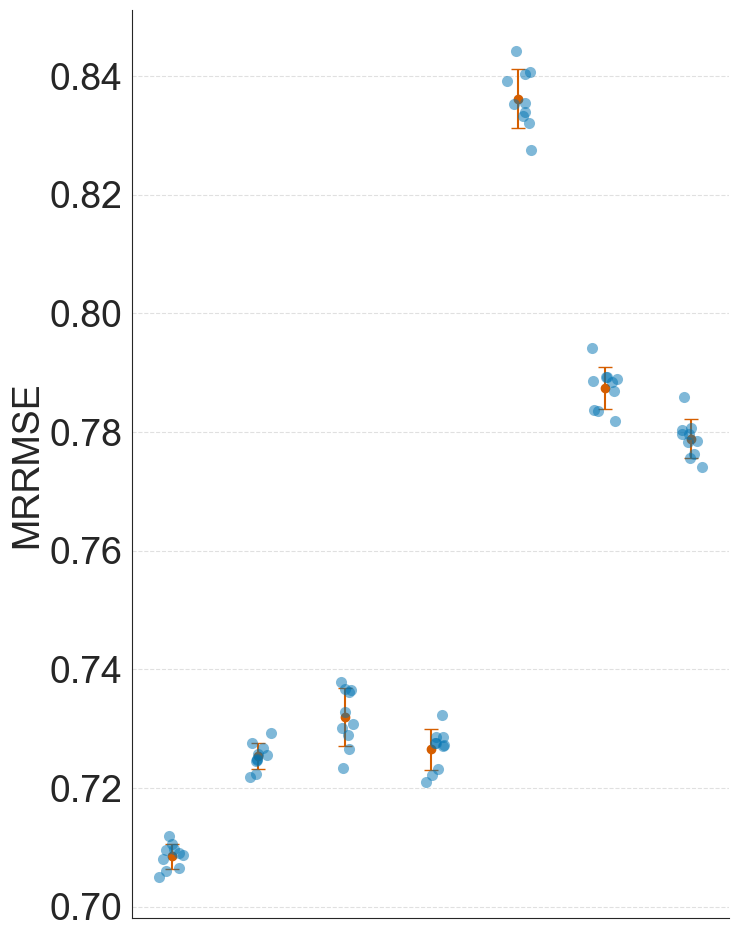

In [241]:
df = df[df.method_id.isin(["jn_ap_op2", "lgc_ensemble", "nn_retraining_with_pseudolabels", "scape", "pyboost", "mean_across_celltypes", "transformer_ensemble"])]

# Rename the method IDs to more descriptive names
rename_dict = {
    "jn_ap_op2": "JN-AP-OP2",
    "lgc_ensemble": "LSTM-GRU-CNN Ensemble",
    "nn_retraining_with_pseudolabels": "NN retraining with pseudolabels",
    "scape": "ScAPE",
    "pyboost": "Py-boost",
    "mean_across_celltypes": "Mean per cell type and gene",
    "transformer_ensemble": "Transformer Ensemble"
}
df['method_id'] = df['method_id'].map(rename_dict)

# Define your custom order as a list of method names in the desired order
order = ["NN retraining with pseudolabels", "ScAPE", "LSTM-GRU-CNN Ensemble", "Py-boost", "JN-AP-OP2", "Transformer Ensemble", "Mean per cell type and gene"]

df = df.melt(id_vars=['method_id'], var_name='Measurement', value_name='Value')

# Calculate mean and standard deviation
stats = df.groupby('method_id')['Value'].agg(['mean', 'std'])
stats.reset_index(inplace=True)

palette = sns.color_palette("colorblind")

sns.set_style("whitegrid")
sns.set_style("white")

# Set font size globally for the plot
matplotlib.rcParams.update({'font.size': 27})

# Plotting
plt.figure(figsize=(8, 10))
ax = plt.gca()

# Using seaborn to create the strip plot with an explicit order
strip_plot = sns.stripplot(x='method_id', y='Value', data=df, ax=ax, jitter=0.15, alpha=0.5, order=order, color=palette[0], size=8)

# Add error bars for mean and standard deviation at correct positions
for i, method in enumerate(order):
    mean = stats.loc[stats['method_id'] == method, 'mean'].values[0]
    std = stats.loc[stats['method_id'] == method, 'std'].values[0]
    ax.errorbar(i, mean, yerr=std, fmt='o', capsize=5, color=palette[3])
ax.grid(axis='y', linestyle='--', alpha=0.6)

# plt.xlabel('Method')
# plt.xlabel('MRRMSE')
plt.ylabel('MRRMSE')
plt.xlabel('')
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xticklabels([])
plt.title('Comparison of Model Performances with Strip Plot and Error Bars')
plt.title("")
# plt.xticks(rotation=45, ha='right')  # Rotate the method IDs for better readability
plt.tight_layout()
plt.savefig("stability_plot.svg", transparent=True)
plt.show()